In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import numba
from numba import njit,jit
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [3]:
a = sciIO.readsav('../B0.sav')
print(a.keys())

C:\Users\Pjer1\Anaconda3\envs\torch15\lib\site-packages\scipy\io\idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


dict_keys(['twbox'])
time: 2.75 s


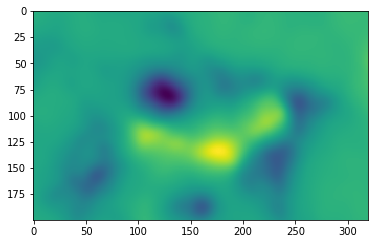

time: 260 ms


In [4]:

# need to be transposed because of the storage toplogy
Bx = np.transpose(a.twbox[0].bx,(2,1,0))
By = np.transpose(a.twbox[0].by,(2,1,0))
Bz = np.transpose(a.twbox[0].bz,(2,1,0))

Bx_gpu = np.zeros(0)
By_gpu = np.zeros(0)
Bz_gpu = np.zeros(0)

plt.imshow(Bz[350:670,200:400,10].T) # x,y.z
#plt.imshow(Bz[:,:,0].T)

In [6]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy
import os

print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineAdaptive.cu", "rt")
traceFunc =SourceModule(traceFunc_file.read(), include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = traceFunc.get_function("TraceAllBline")
print('kernel compiled')

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = gpuarray.to_gpu(Bx.astype(np.float32))
    By_gpu = gpuarray.to_gpu(By.astype(np.float32))
    Bz_gpu = gpuarray.to_gpu(Bz.astype(np.float32))

compiling kernel
kernel compiled
transfering B-field to GPU
time: 9.86 s


In [7]:
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
print(BshapeN)
BshapeN = gpuarray.to_gpu(BshapeN)

interp_ratio=4
x_range = [0,1163]
y_range = [0,487]
#x_range = [350,670]
#y_range = [200,400]
x_i = np.linspace(*x_range, np.uint32(interp_ratio*(x_range[1]-x_range[0])))
y_i = np.linspace(*y_range, np.uint32(interp_ratio*(y_range[1]-y_range[0])))
x_arr,y_arr = np.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten().astype(np.float32)
y_inp = y_arr.flatten().astype(np.float32)
z_inp = (np.zeros_like(x_inp)).astype(np.float32)
#z_inp[:] = +23.583333

(x_start,y_start,z_start, x_end,y_end,z_end,
 Bx_start,By_start,Bz_start,  Bx_end,By_end,Bz_end,   Bx_inp,By_inp,Bz_inp
)=[gpuarray.to_gpu(np.zeros_like(x_inp).astype(np.float32)) for _ in range(15)]

flag_start=flag_end=gpuarray.to_gpu(np.zeros_like(x_inp).astype(np.int32))

line_len = gpuarray.to_gpu(np.zeros_like(x_inp).astype(np.float64))
N        = gpuarray.to_gpu(np.ulonglong([x_inp.shape[0]]))
s_len    = gpuarray.to_gpu(np.float32([1./4.]))

x_inp = gpuarray.to_gpu(x_inp)
y_inp = gpuarray.to_gpu(y_inp)
z_inp = gpuarray.to_gpu(z_inp)

inp_norm = gpuarray.to_gpu(np.array([0,0,1],dtype=np.float32))

# for GTX 1060
#blck=(64,1,1)
#grd = (20,1)

# for GTX1080ti
blck=(128,1,1)
grd = (28,1)


[1164  488  488]
time: 1.97 s


In [8]:
# run the big calclation
TraceAllBline(Bx_gpu,By_gpu,Bz_gpu,BshapeN,
            x_inp,y_inp,z_inp,inp_norm,
            x_start, y_start, z_start, flag_start,
            x_end,   y_end,   z_end,   flag_end,
            Bx_inp,  By_inp,  Bz_inp,
            Bx_start,By_start,Bz_start,
            Bx_end,  By_end,  Bz_end,  
            s_len,N,line_len,block=blck,grid=grd)

pycuda.driver.Context.synchronize()

time: 2.27 s


In [9]:
x_end_arr = x_end.reshape(xy_shape)
y_end_arr = y_end.reshape(xy_shape)

x_start_arr = x_start.reshape(xy_shape)
y_start_arr = y_start.reshape(xy_shape)

flags_arr = flag_end.reshape(xy_shape)
Bz_arr_in_z = Bz_start.reshape(xy_shape)
Bz_arr_out_z = Bz_end.reshape(xy_shape)
Bz_arr_0_z = Bz_inp.reshape(xy_shape)

time: 1.97 ms


In [10]:
x_end_arr = x_end.get().reshape(xy_shape)
y_end_arr = y_end.get().reshape(xy_shape)
x_start_arr = x_start.get().reshape(xy_shape)
y_start_arr = y_start.get().reshape(xy_shape)

flags_arr = flag_end.get().reshape(xy_shape)
Bz_arr_in_z = Bz_start.get().reshape(xy_shape)
Bz_arr_out_z = Bz_end.get().reshape(xy_shape)
Bz_arr_0_z = Bz_inp.get().reshape(xy_shape)

time: 235 ms


In [11]:
dx2xc = x_end_arr[2:,1:-1]-x_end_arr[0:-2,1:-1];
dx2yc = x_end_arr[1:-1,2:]-x_end_arr[1:-1,0:-2];
dy2xc = y_end_arr[2:,1:-1]-y_end_arr[0:-2,1:-1];
dy2yc = y_end_arr[1:-1,2:]-y_end_arr[1:-1,0:-2];

dx1xc = x_start_arr[2:,1:-1]-x_start_arr[0:-2,1:-1];
dx1yc = x_start_arr[1:-1,2:]-x_start_arr[1:-1,0:-2];
dy1xc = y_start_arr[2:,1:-1]-y_start_arr[0:-2,1:-1];
dy1yc = y_start_arr[1:-1,2:]-y_start_arr[1:-1,0:-2];

time: 234 ms


In [12]:
a = (dx2xc*dy1yc-dx2yc*dy1xc);
b = (dx2yc*dx1xc-dx2xc*dx1yc);
c = (dy2xc*dy1yc-dy2yc*dy1xc);
d = (dy2yc*dx1xc-dy2xc*dx1yc);

bnr = np.abs(Bz_arr_in_z[1:-1,1:-1])/(np.abs(Bz_arr_0_z[1:-1,1:-1])**2) *np.abs(Bz_arr_out_z[1:-1,1:-1]) *((interp_ratio/2)**4)

Q = (a**2+b**2+c**2+d**2)*bnr
Q[np.where(Q<1.0)]=1.0


time: 999 ms


Text(0.5, 1.0, 'Length histogram')

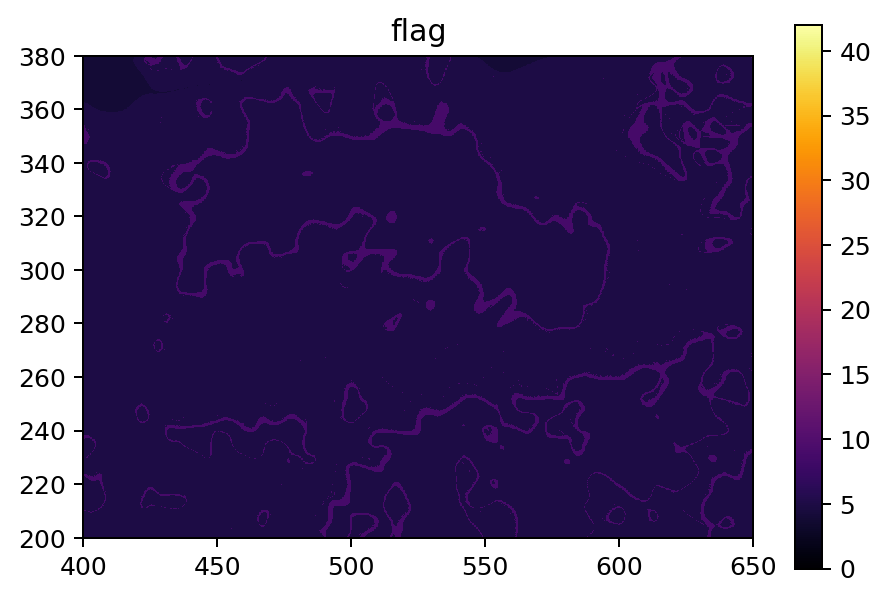

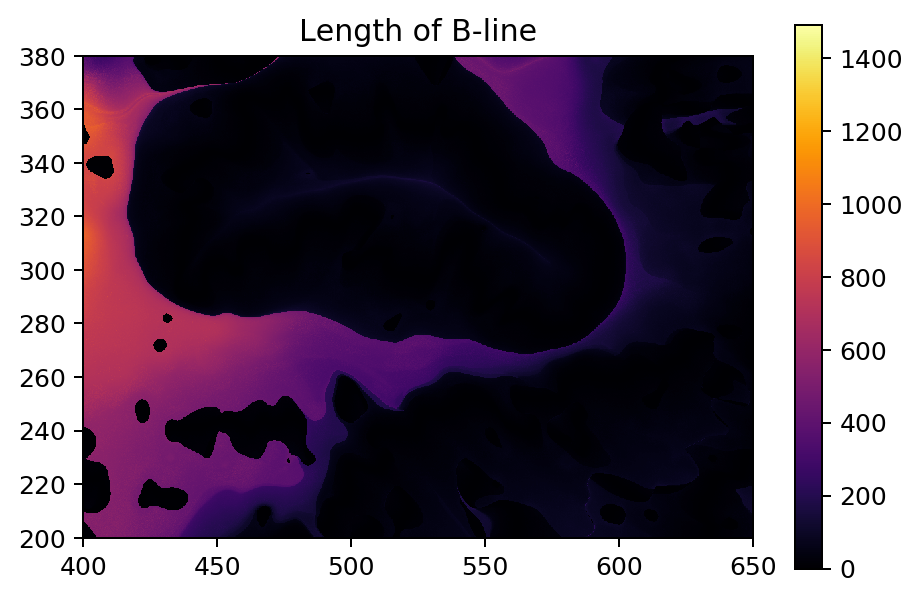

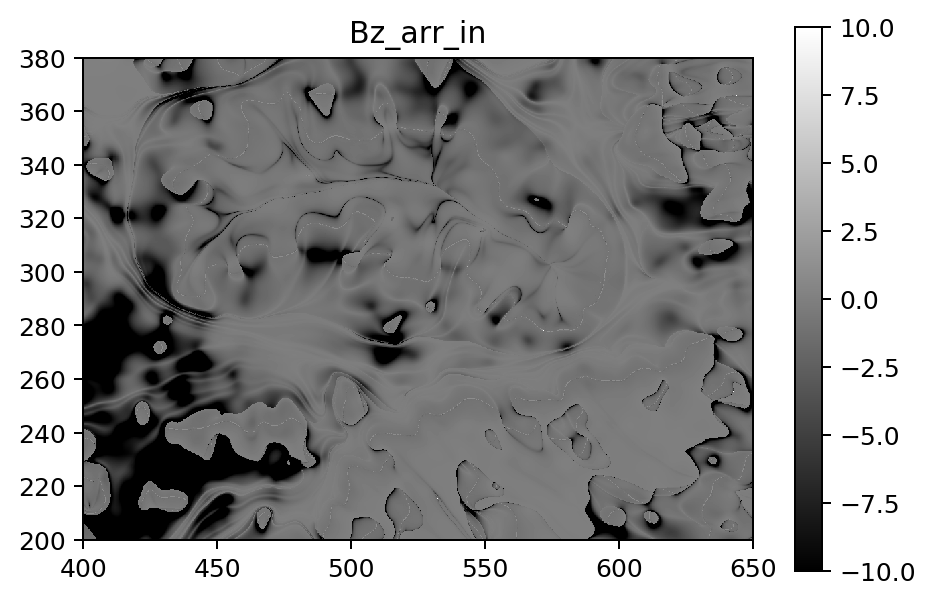

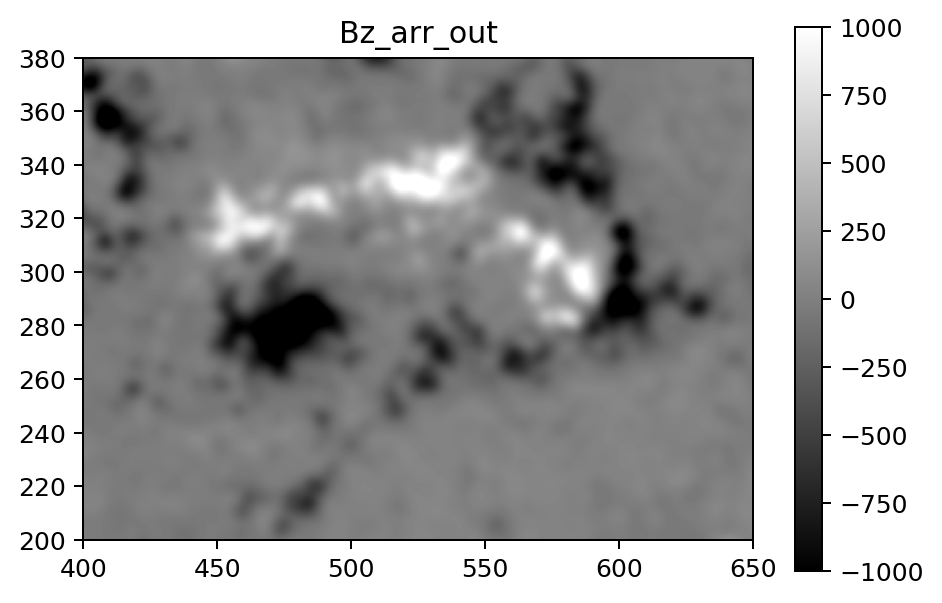

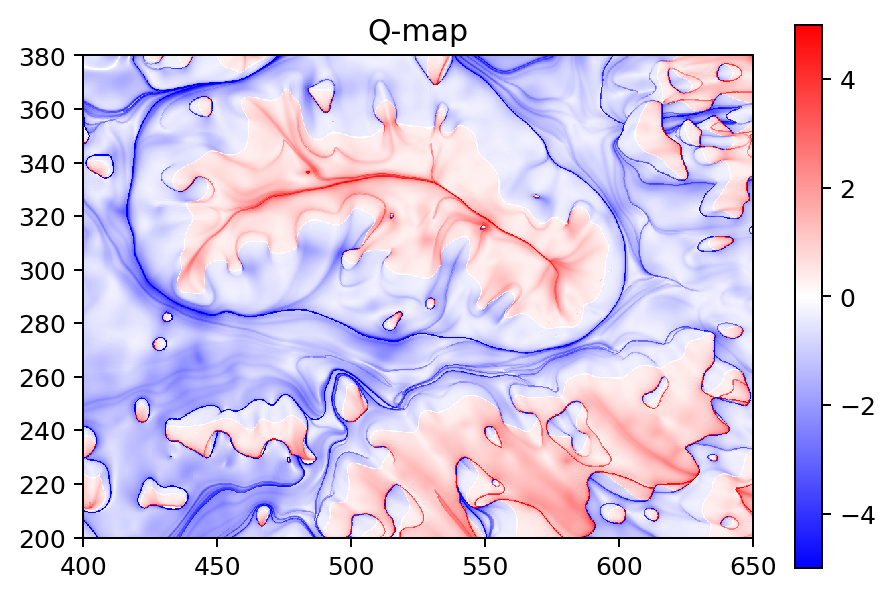

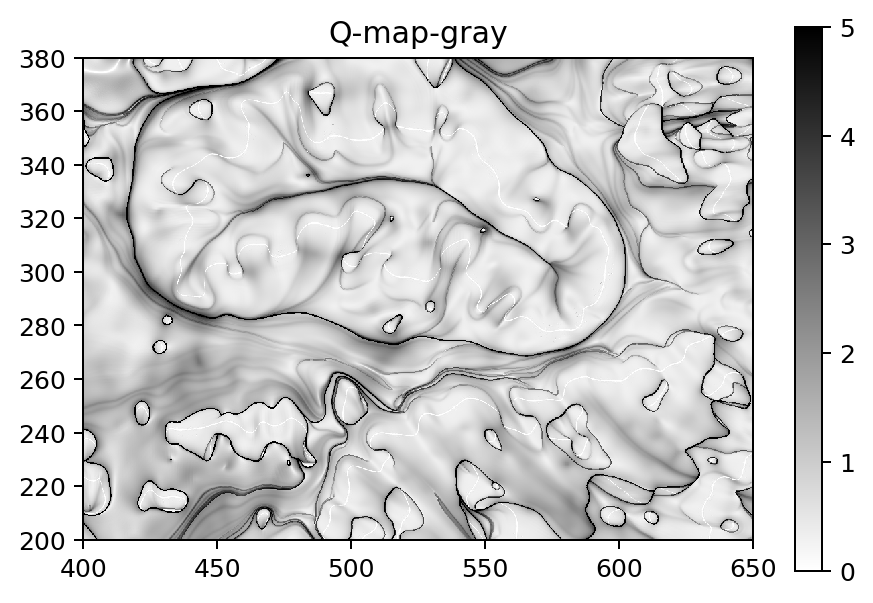

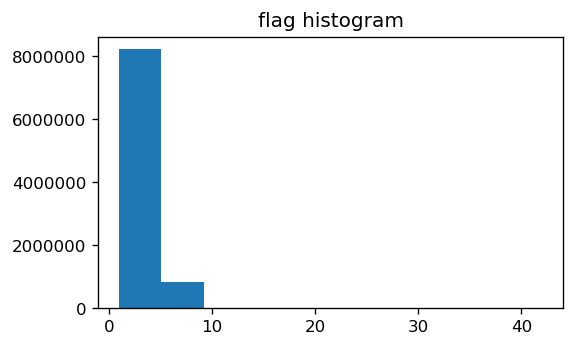

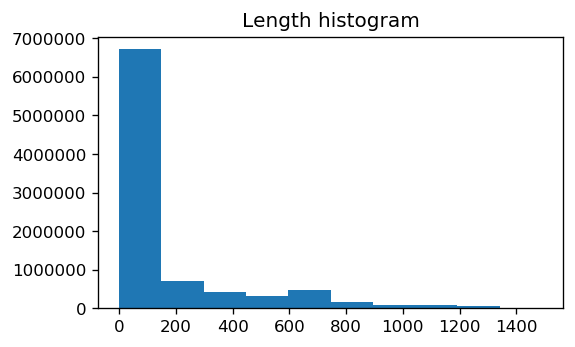

time: 6.55 s


In [13]:
plt.close()

xxlim=None
yylim=None

#xxlim=[400,510]
#yylim=[300,380]
xxlim=[400,650]
yylim=[200,380]


dpi=180

fig=plt.figure(0,dpi=dpi); ax = plt.gca() 
img=ax.imshow(flags_arr,cmap='inferno',origin='lower',vmin=0,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('flag')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(1,dpi=dpi); ax = plt.gca() 
img=ax.imshow(line_len.get().reshape(xy_shape),cmap='inferno',origin='lower',
              vmin=0,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Length of B-line')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_arr_in_z/Bz_arr_out_z,cmap='gray',origin='lower',
              vmax=10,vmin=-10,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_in')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_arr_0_z,cmap='gray',origin='lower',vmax=1000,vmin=-1000,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_out')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(4,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q)*np.sign(Bz_arr_0_z[1:-1,1:-1])*(flags_arr[1:-1,1:-1]<np.inf),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


fig=plt.figure(5,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q)*(flags_arr[1:-1,1:-1]<41),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',extent=[*x_range,*y_range])
#ax.contour(flags_arr,origin='lower',extent=[*x_range,*y_range])

fig.colorbar(img)
ax.set_title('Q-map-gray')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


plt.figure(10,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(flag_end.get())
ax.set_title('flag histogram')

plt.figure(11,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(line_len.get())
ax.set_title('Length histogram')


<ipython-input-14-39e9c6ee1942>:2: RuntimeWarning: divide by zero encountered in log
  img = ax.imshow(np.log((a)**2),cmap='inferno',origin='lower',vmax=0.3,vmin=-10,extent=[*x_range,*y_range])


(200, 380)

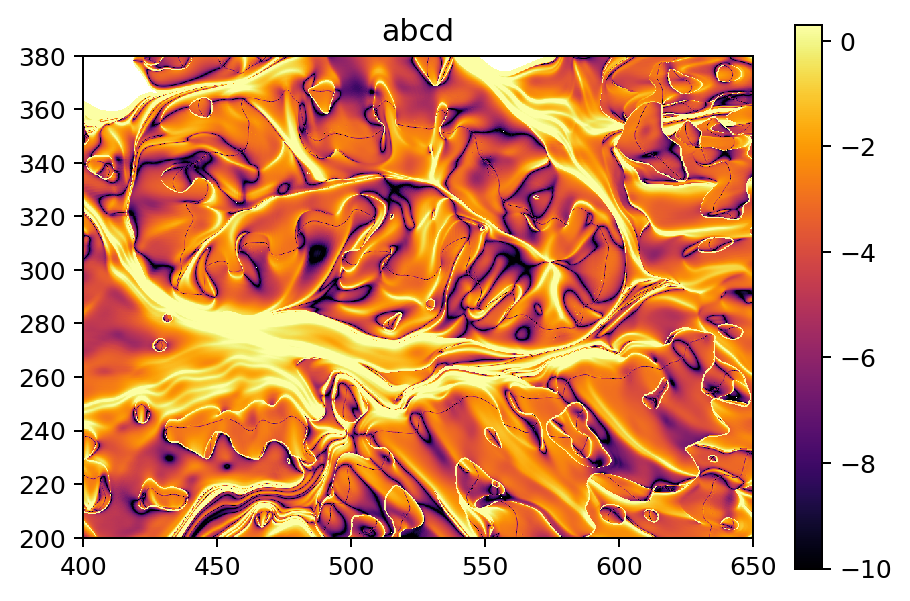

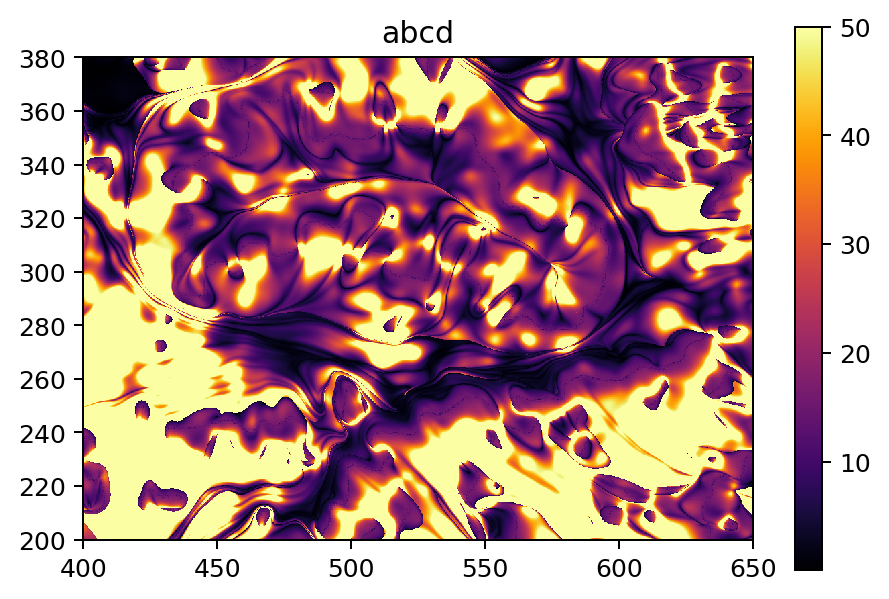

time: 2.36 s


In [14]:
fig=plt.figure(1,dpi=180); ax = plt.gca() 
img = ax.imshow(np.log((a)**2),cmap='inferno',origin='lower',vmax=0.3,vmin=-10,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=180); ax = plt.gca() 
img = ax.imshow((bnr),vmax=50,cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


In [15]:
bnr

array([[1.9232653e+01, 6.9292026e+03, 1.2010089e+02, ..., 3.1483938e+01,
        3.6236015e+01, 1.0597395e+01],
       [1.8234753e+01, 3.2000519e+01, 4.1681174e+02, ..., 3.0950930e+01,
        3.5252571e+01, 3.9881889e+01],
       [1.7594551e+01, 2.3311583e+01, 2.8673275e+05, ..., 3.0475422e+01,
        3.4369904e+01, 3.8188457e+01],
       ...,
       [8.7838955e+00, 7.8070307e+00, 6.8735914e+00, ..., 6.0680836e+01,
        1.1194008e+07, 3.4148464e+01],
       [1.1935172e+01, 1.0218660e+01, 8.9502897e+00, ..., 1.2687426e+01,
        2.2457843e+00, 5.6967688e+00],
       [1.4704016e+01, 1.2936578e+01, 1.1125175e+01, ..., 2.4280384e+00,
        1.4600101e+01, 6.7059410e+01]], dtype=float32)

time: 3.99 ms
